In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from scipy.spatial import ConvexHull, Voronoi
import seaborn as sns
import shapely
import shapely.geometry
import shapely.ops
from sklearn.cluster import KMeans
import trimesh
import trimesh.creation as tc
sns.set()

In [2]:
viet_mesh = pv.read('./viet/V2_2_105.75_15.98_tile_1_1.stl')
viet_plane = viet_mesh.project_points_to_plane().points
viet_edge = viet_mesh.project_points_to_plane().extract_feature_edges().points
viet_bounds = viet_mesh.bounds

n_pieces = 16

In [3]:
kmeans = KMeans(n_clusters=n_pieces, random_state=0).fit(viet_plane[:,:2])
clusters = kmeans.predict(viet_plane[:,:2])
vor = Voronoi(kmeans.cluster_centers_, qhull_options='Qbb Qc Qx')

region_bbox = shapely.geometry.Polygon(zip(
    [viet_plane[:,0].min()-5, viet_plane[:,0].min()-5, viet_plane[:,0].max()+5, viet_plane[:,0].max()+5, viet_plane[:,0].min()-5], 
    [viet_plane[:,1].min()-5, viet_plane[:,1].max()+5, viet_plane[:,1].max()+5, viet_plane[:,1].min()-5, viet_plane[:,1].min()-5]
))

In [4]:
viet_plane_df = pd.DataFrame(viet_plane, columns=['x','y','z'])
viet_plane_df['cluster'] = clusters

pieces = []
for g, gdf in viet_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)

In [5]:
connected_pieces = []
for idx, p0 in enumerate(pieces):
    for jdx, p1 in enumerate(pieces[idx+1:], idx+1):
        if idx == jdx: continue
        line = shapely.geometry.LineString([p0.centroid, p1.centroid])
        poly_intersections = [(i, line.intersection(p).length) for i, p in enumerate(pieces) if line.intersects(p)]
        if len(poly_intersections) == 2:
            if (poly_intersections[0][1] + poly_intersections[1][1]) / line.length > 0.9:
                connected_pieces.append([(i,pieces[i].centroid.coords[0]) for i, length in poly_intersections])
        
for (i, c0),(j,c1) in connected_pieces:
    line = shapely.geometry.LineString([c0, c1])
    near_center_point = line.interpolate(0.65, normalized=True)
    near_center_point_poly = shapely.geometry.LineString([line.coords[0], near_center_point]).buffer(0.5)
    near_center_point_buffer = near_center_point.buffer(1.5)
    x, y = near_center_point_buffer.exterior.xy
    
    x.append(x[0])
    y.append(y[0])
    near_center_point_buffer = shapely.geometry.Polygon(zip(x[::3],y[::3]))
    near_center_point_poly = shapely.ops.cascaded_union([near_center_point_poly, near_center_point_buffer])
    
    pieces[i] = shapely.ops.cascaded_union([pieces[i], near_center_point_poly]).buffer(-0.01)
    pieces[j] = pieces[j].difference(near_center_point_poly.buffer(0.01))

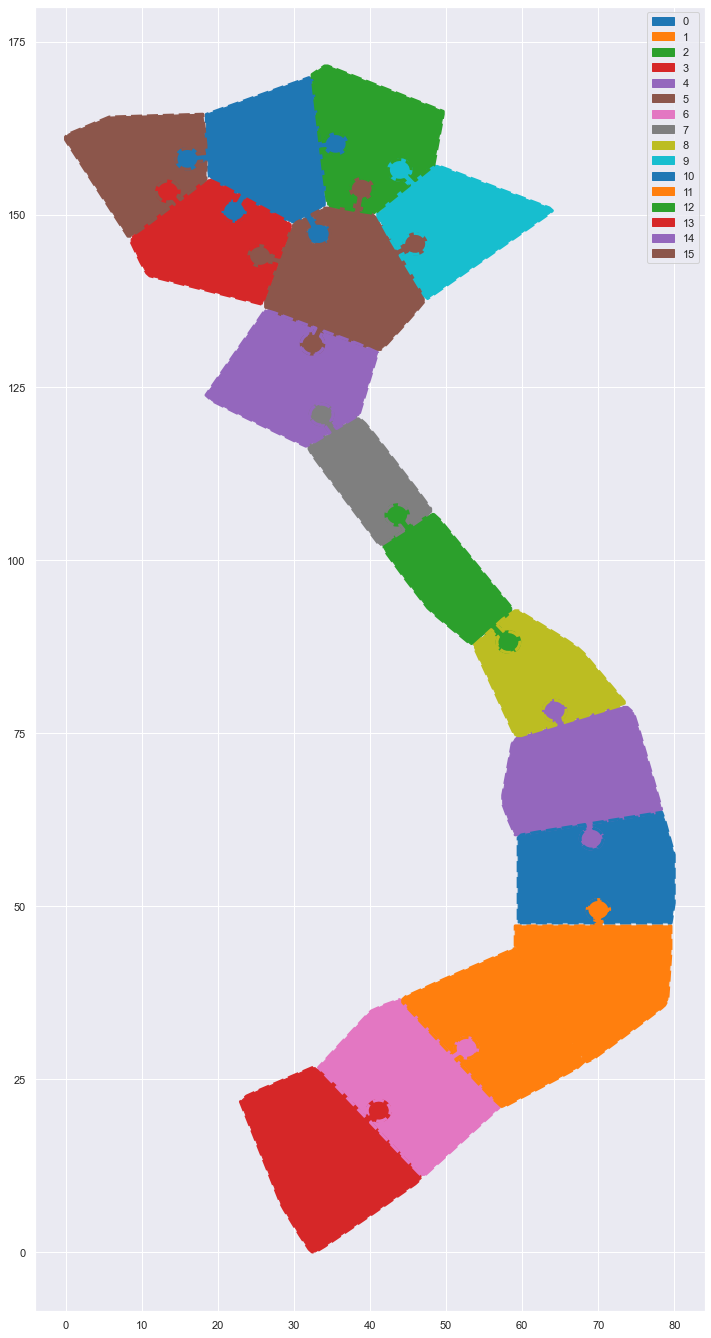

In [6]:
fig, ax = plt.subplots(1, figsize=(12,24))
# ax.scatter(viet_plane[:,0], viet_plane[:,1], c=clusters, alpha=1, s=10)
# ax.scatter(viet_edge[:,0], viet_edge[:,1], alpha=0.4)
c = plt.cm.tab10.colors
for idx, p in enumerate(pieces):
    x, y = p.exterior.xy
    plt.plot(x,y,lw=3,ls='--', c=c[idx%len(c)])
    plt.fill(x,y, c=c[idx%len(c)], label=f'{idx}')
plt.legend()
plt.show()

In [7]:
for idx, p in enumerate(pieces):
    print(f"Pieces/{idx+1:04}_{len(pieces):04}")
    piece = tc.extrude_polygon(p, 1)
    piece = piece.apply_transform(
        trimesh.transformations.scale_and_translate(
            scale=[1,1,viet_bounds[5]+2], 
            translate=[0,0,-1]
        )
    )
    piece = pv.wrap(piece)
    vox = pv.voxelize(piece, density=piece.length/200)
    piece = vox.clip_surface(viet_mesh).extract_surface()

    piece.save(f"Pieces/viet_mesh_{idx+1:04}_{len(pieces):04}.stl")

Pieces/0001_0016
Pieces/0002_0016
Pieces/0003_0016
Pieces/0004_0016
Pieces/0005_0016
Pieces/0006_0016
Pieces/0007_0016
Pieces/0008_0016
Pieces/0009_0016
Pieces/0010_0016
Pieces/0011_0016
Pieces/0012_0016
Pieces/0013_0016
Pieces/0014_0016
Pieces/0015_0016
Pieces/0016_0016


In [8]:
assert
mesh_pieces = []
for idx, p in enumerate(pieces):
    mesh_piece = []
    for t in tc.extrude_polygon(p, 1).triangles:
        t = np.vstack([t, [t[0]]])
        mesh_piece.append(t)
        plt.plot(t[:,0], t[:,1])
    mesh_pieces.append(mesh_piece)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-8-1999e719abce>, line 1)